# Exploratory Data Analysis:

Worksheets: ['in']

Numeric summary:


,count,mean,std,min,25%,median,75%,max
age,701.0,67.138374,15.353993,20.0000,56.0,68.0,76.0,100.0
weight,701.0,181.355207,64.174367,83.0000,131.0,168.0,205.0,384.0
height,689.0,66.842961,4.620516,52.0000,64.0,67.0,70.0,79.0
impedance,682.0,14.369761,15.125810,0.0315,6.0,11.0,17.8,170.0
tewl,533.0,61.376548,16.944472,5.6000,50.0,63.1,74.4,107.1



Value counts for location:


,count,percent
location,,
NaN,732,52.1
leg,306,21.8
foot,163,11.6
ankle,46,3.3
heel,44,3.1
buttocks,44,3.1
hip,24,1.7
toe,13,0.9
arm,11,0.8


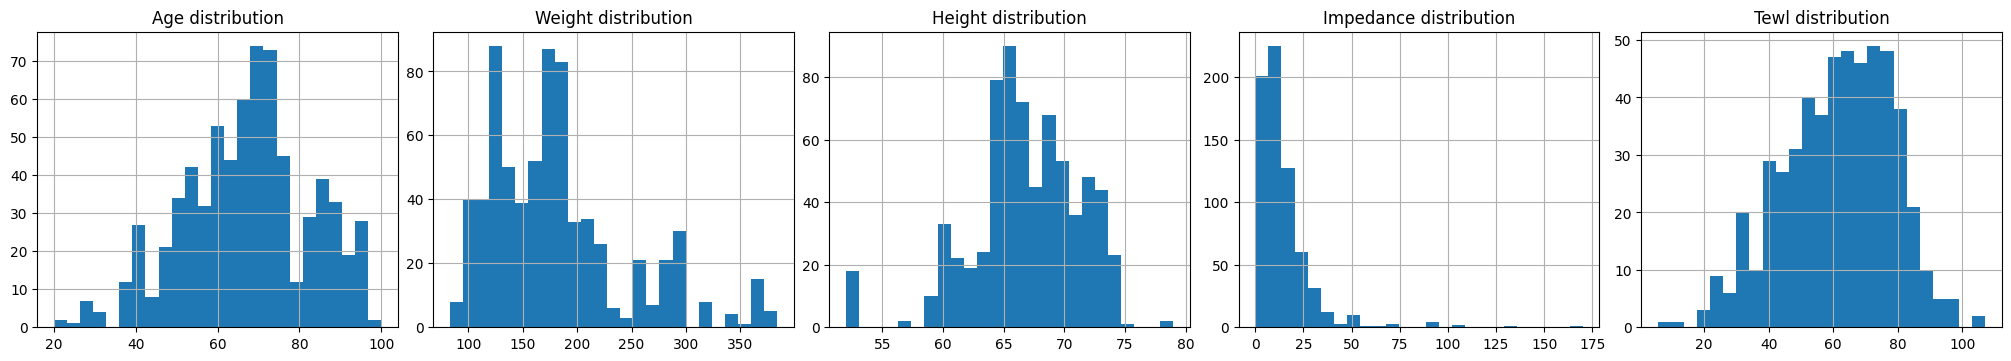

In [1]:
# -----------------------------------------------------------
# 0.  Environment & housekeeping
# -----------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Use your own style settings if you prefer.
plt.style.use("default")      # <- remove or change to 'ggplot', etc.
pd.set_option("display.max_columns",  None)
pd.set_option("display.width",        120)

# -----------------------------------------------------------
# 1.  Load the workbook ▸  pick the main sheet automatically
# -----------------------------------------------------------
xl = pd.ExcelFile("clinicaldata_april5_2021_wDx_updated.xlsx")
print("Worksheets:", xl.sheet_names)
df  = xl.parse(xl.sheet_names[0])

# -----------------------------------------------------------
# 2.  Basic data hygiene
#     (a) consistent column names
#     (b) coerce numeric fields
# -----------------------------------------------------------
df.columns = (
    df.columns.str.strip()          # kill invisible spaces
              .str.lower()
              .str.replace(" ", "_")
              .str.replace("\(cm\)", "", regex=True) # remove (cm) from column names
)

# Identify existing numeric columns
existing_numeric_cols = ["age", "weight", "height", "temperature", "impedance", "length", "width", "tewl"]
numeric_cols = [col for col in existing_numeric_cols if col in df.columns]


for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# -----------------------------------------------------------
# 3.  Descriptive statistics
# -----------------------------------------------------------
# --- continuous variables
desc_numeric = (df[numeric_cols]
                .describe()
                .T
                .rename(columns={"50%":"median"}))
print("\nNumeric summary:")
display(desc_numeric)

# --- categorical variables
cat_cols = ["location", "wound_type"]
for c in cat_cols:
    if c in df.columns:
        freq = (df[c]
                .value_counts(dropna=False)
                .rename_axis(c)
                .to_frame("count")
                .assign(percent=lambda x: round(100*x["count"]/x["count"].sum(),1)))
        print(f"\nValue counts for {c}:")
        display(freq.head(20))

# -----------------------------------------------------------
# 4.  Quick visualisations  (feel free to comment out)
# -----------------------------------------------------------
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(4 * len(numeric_cols), 3.5), constrained_layout=True)
if len(numeric_cols) == 1:
    axes = [axes] # Make axes iterable if there is only one subplot
for ax, col in zip(axes, numeric_cols):
    if col in df.columns:
        df[col].hist(ax=ax, bins=25)
        ax.set_title(f"{col.capitalize()} distribution")
plt.show()

# Box‑and‑whisker of wound length vs type
if {"length", "wound_type"} <= set(df.columns):
    plt.figure(figsize=(6,4))
    df.boxplot(column="length", by="wound_type", showfliers=False)
    plt.title("Length by wound type"); plt.suptitle("")
    plt.ylabel("Length (cm)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Numeric summary (NaNs removed row‑wise):


,count,mean,std,min,25%,50%,75%,max
age,701.0,67.138374,15.353993,20.0000,56.0,68.0,76.0,100.0
weight,701.0,181.355207,64.174367,83.0000,131.0,168.0,205.0,384.0
height,689.0,66.842961,4.620516,52.0000,64.0,67.0,70.0,79.0
impedance,682.0,14.369761,15.125810,0.0315,6.0,11.0,17.8,170.0
tewl,533.0,61.376548,16.944472,5.6000,50.0,63.1,74.4,107.1


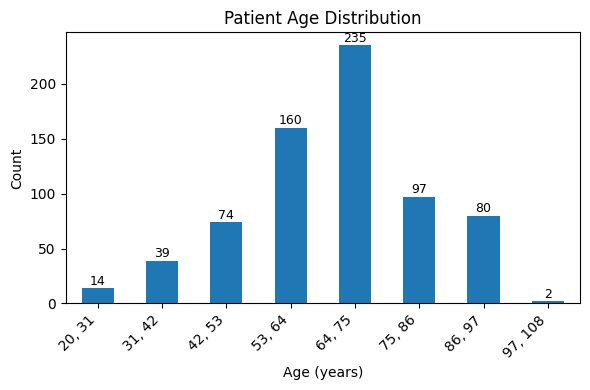

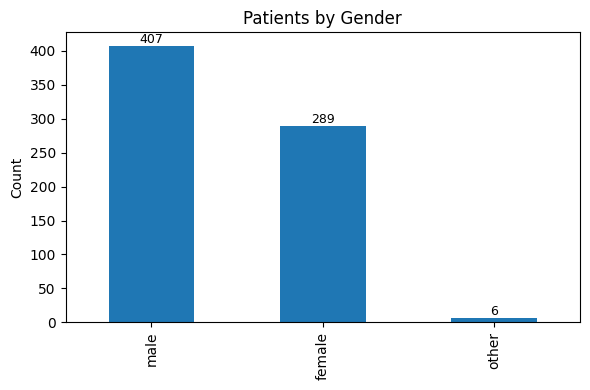

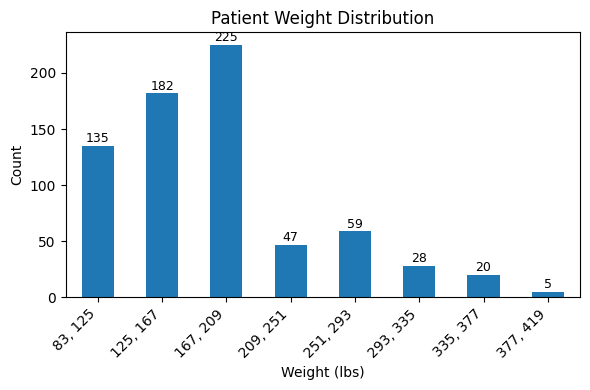

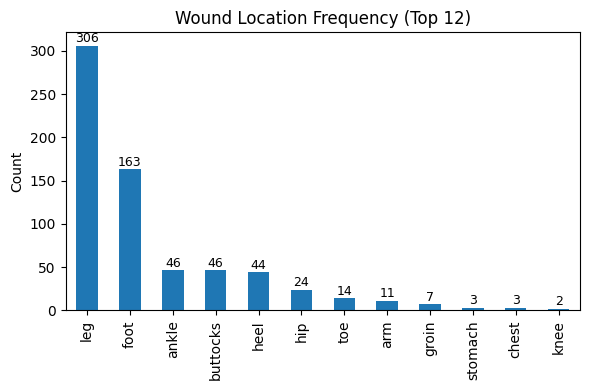

In [2]:
# -----------------------------------------------------------
# 0.  Imports & I/O
# -----------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

xl = pd.ExcelFile("clinicaldata_april5_2021_wDx_updated.xlsx")
df = xl.parse(xl.sheet_names[0])

# -----------------------------------------------------------
# 1.  Light‑touch cleaning
# -----------------------------------------------------------
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.dropna(how='all', inplace=True)

# Coerce obvious numerics
num_cols = ["age", "weight", "height", "temperature",
            "impedance", "length", "width", "tewl"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# -----------------------------------------------------------
# 2.  Helper functions
# -----------------------------------------------------------
def summary_series(s: pd.Series) -> pd.Series:
    """Return count/mean/std/min/quantiles/median/max after dropping NaNs."""
    return s.dropna().describe()

def hist_with_labels(s: pd.Series, bins, title, xlabel, outfile):
    """Histogram with explicit bin edges & value‑labels."""
    # Bin manually so labels stay exact
    binned = pd.cut(s.dropna(), bins=bins, right=True, include_lowest=True)
    counts = binned.value_counts().sort_index()

    ax = counts.plot(kind="bar", figsize=(6,4))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Count")
    ax.set_xticklabels([f"{idx.left:.0f}, {idx.right:.0f}" for idx in counts.index],
                       rotation=45, ha='right')
    # write counts on top
    for i, v in enumerate(counts):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    # plt.savefig(OUT_DIR/outfile, dpi=300)
    plt.show()

def bar_with_labels(counts, title, xlabel, outfile):
    """Simple bar‑chart with value labels."""
    ax = counts.plot(kind="bar", figsize=(6,4))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Count")
    for i, v in enumerate(counts):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    # plt.savefig(OUT_DIR/outfile, dpi=300)
    plt.show()

# -----------------------------------------------------------
# 3.  Descriptive stats **after** NaN removal
# -----------------------------------------------------------
desc = pd.concat({c: summary_series(df[c]) for c in ["age", "weight", "height",
                                                     "impedance", "tewl"]}, axis=1).T
print("Numeric summary (NaNs removed row‑wise):")
display(desc)

# -----------------------------------------------------------
# 4.  Recreate Figure 2‑style plots
# -----------------------------------------------------------

## 4‑A  Age histogram • bins 11 yr each
age_bins = [20, 31, 42, 53, 64, 75, 86, 97, 108]
hist_with_labels(df["age"], age_bins,
                 "Patient Age Distribution", "Age (years)",
                 "age_hist.png")

## 4‑B  Sex / gender counts  (rename col if needed)
if "gender" in df.columns:
    gender_counts = df["gender"].dropna().value_counts()
    bar_with_labels(gender_counts,
                    "Patients by Gender", "", "gender_bar.png")

## 4‑C  Weight histogram • bins width = 42 lb
weight_bins = [83, 125, 167, 209, 251, 293, 335, 377, 419]
hist_with_labels(df["weight"], weight_bins,
                 "Patient Weight Distribution", "Weight (lbs)",
                 "weight_hist.png")

## 4‑D  Wound‑type frequencies
if "wound_type" in df.columns:
    wt_counts = df["wound_type"].dropna().value_counts()
    bar_with_labels(wt_counts,
                    "Wound Type Frequency", "", "woundtype_bar.png")

## 4‑E  Wound‑location frequencies  – show top 12
if "location" in df.columns:
    loc_counts = (df["location"]
                  .str.lower().str.strip()       # basic normalisation
                  .dropna()
                  .replace({"buttock":"buttocks"})   # example fix‑ups
                  .value_counts()
                  .head(12))
    bar_with_labels(loc_counts,
                    "Wound Location Frequency (Top 12)", "", "location_bar.png")

# -----------------------------------------------------------
# 5.  (Optional) export summary table to CSV
# -----------------------------------------------------------
# desc.to_csv("outputs/descriptives/numeric_summary_noNaN.csv")


In [3]:
# Calculate the mean of numerical columns ('age', 'weight', 'height', 'impedance', 'tewl') grouped by 'type'
if "type" in df.columns and all(col in df.columns for col in ['age', 'weight', 'height', 'impedance', 'tewl']):
    wound_type_numeric_agg = df.groupby('type')[['age', 'weight', 'height', 'impedance', 'tewl']].mean()
    print("Mean of numerical columns grouped by wound type ('type' column):")
    display(wound_type_numeric_agg)
else:
    print("Could not calculate mean of numerical columns grouped by wound type ('type' column).")

# Calculate the mean of numerical columns ('age', 'weight', 'height', 'impedance', 'tewl') grouped by 'location'
if "location" in df.columns and all(col in df.columns for col in ['age', 'weight', 'height', 'impedance', 'tewl']):
    location_numeric_agg = df.groupby('location')[['age', 'weight', 'height', 'impedance', 'tewl']].mean()
    print("\nMean of numerical columns grouped by location:")
    display(location_numeric_agg)
else:
    print("Could not calculate mean of numerical columns grouped by location.")

# Create a contingency table (cross-tabulation) of 'type' and 'ishealed'
if "type" in df.columns and "ishealed" in df.columns:
    wound_type_healed_contingency = pd.crosstab(df['type'], df['ishealed'])
    print("\nContingency table for wound type ('type' column) and healing status:")
    display(wound_type_healed_contingency)
else:
    print("Could not create contingency table for wound type ('type' column) and healing status.")

# Create a contingency table of 'location' and 'ishealed'
if "location" in df.columns and "ishealed" in df.columns:
    location_healed_contingency = pd.crosstab(df['location'], df['ishealed'])
    print("\nContingency table for location and healing status:")
    display(location_healed_contingency)
else:
    print("Could not create contingency table for location and healing status.")

Mean of numerical columns grouped by wound type ('type' column):


,age,weight,height,impedance,tewl
type,,,,,
DFU,61.284024,230.082840,69.570552,17.496524,61.503361
Other,65.078125,159.929688,65.777953,14.752794,60.654369
PAD,74.277228,159.118812,65.039604,14.119658,60.694444
PU,61.764151,146.830189,65.673267,11.471262,62.495000
VLU,72.730964,183.451777,66.796954,13.123708,61.495597



Mean of numerical columns grouped by location:


,age,weight,height,impedance,tewl
location,,,,,
ankle,67.065217,147.195652,59.782609,11.995250,60.884375
arm,66.000000,168.000000,62.000000,6.745455,64.045455
buttock,72.000000,250.000000,69.000000,8.950000,107.100000
buttocks,59.363636,146.659091,66.859091,6.923273,68.419444
chest,65.000000,272.000000,71.000000,11.500000,49.950000
foot,61.276074,202.036810,68.280255,16.623687,58.725806
groin,62.000000,199.000000,65.000000,6.400000,74.766667
heel,68.318182,217.840909,68.340909,22.725349,60.711429
hip,48.750000,131.166667,65.833333,8.699167,63.104762



Contingency table for wound type ('type' column) and healing status:


ishealed,No,Yes
type,,
DFU,152,17
Other,97,31
PAD,95,6
PU,96,10
VLU,125,72



Contingency table for location and healing status:


ishealed,No,Yes
location,,
ankle,40,6
arm,11,0
buttock,2,0
buttocks,44,0
chest,0,3
foot,150,13
groin,7,0
heel,40,4
hip,21,3



Generating stacked bar chart for wound type and healing status...


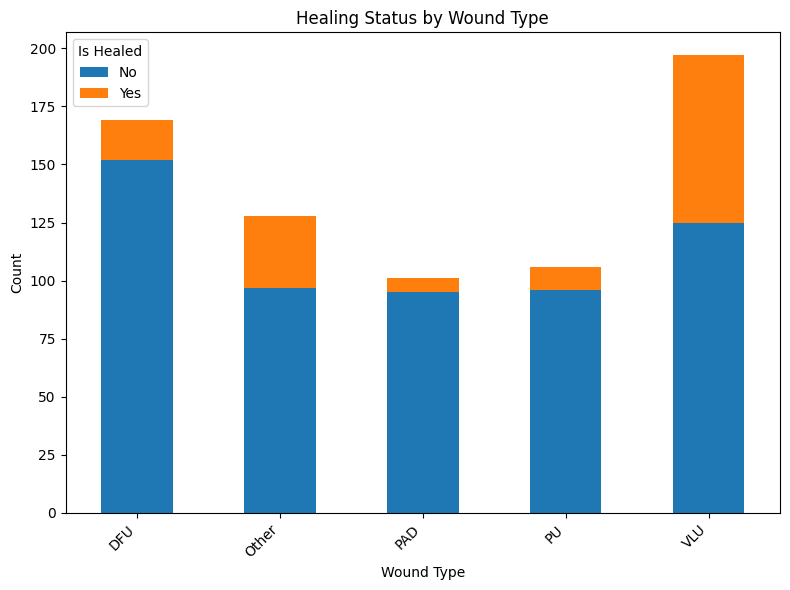


Generating stacked bar chart for wound location and healing status (top 15)...


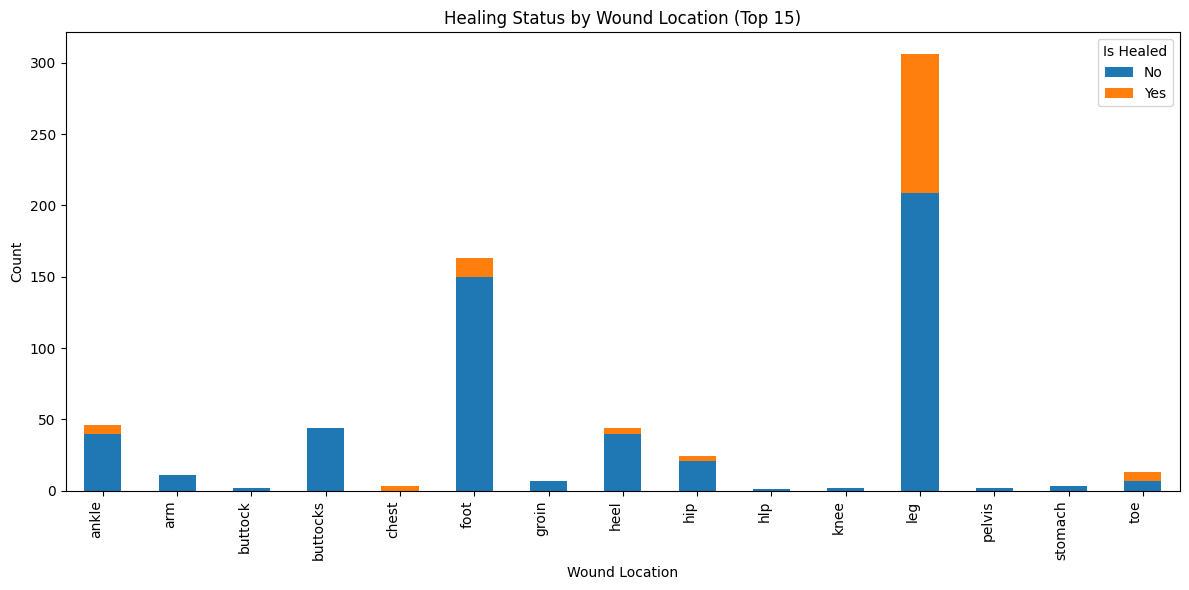

In [4]:
# 1. Stacked bar charts for wound type and healing status
if 'type' in df.columns and 'ishealed' in df.columns:
    print("\nGenerating stacked bar chart for wound type and healing status...")
    wound_type_healed_contingency = pd.crosstab(df['type'], df['ishealed'])
    wound_type_healed_contingency.plot(kind='bar', stacked=True, figsize=(8, 6))
    plt.title('Healing Status by Wound Type')
    plt.xlabel('Wound Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Is Healed')
    plt.tight_layout()
    plt.show()

# 2. Stacked bar charts for wound location and healing status (top 15)
if 'location' in df.columns and 'ishealed' in df.columns:
    print("\nGenerating stacked bar chart for wound location and healing status (top 15)...")
    top_locations = df['location'].value_counts().nlargest(15).index
    df_top_locations = df[df['location'].isin(top_locations)].copy()
    location_healed_contingency = pd.crosstab(df_top_locations['location'], df_top_locations['ishealed'])
    location_healed_contingency.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title('Healing Status by Wound Location (Top 15)')
    plt.xlabel('Wound Location')
    plt.ylabel('Count')
    plt.xticks(rotation=90, ha='right')
    plt.legend(title='Is Healed')
    plt.tight_layout()
    plt.show()


# Modelling with Each Patient Counted Once:


✔  Patient 3rd or more visits table: 90 patients 3-level × 43 features
all             | Logistic Regression  : 72.73%  (n=22)
all             | Decision Tree        : 77.27%  (n=22)
all             | Random Forest        : 86.36%  (n=22)
all             | KNN                  : 90.91%  (n=22)
all             | 4‑layer Perceptron   : 90.91%  (n=22)
reduced         | Logistic Regression  : 81.82%  (n=22)
reduced         | Decision Tree        : 81.82%  (n=22)
reduced         | Random Forest        : 77.27%  (n=22)
reduced         | KNN                  : 81.82%  (n=22)
reduced         | 4‑layer Perceptron   : 86.36%  (n=22)
minimal         | Logistic Regression  : 51.72%  (n=29)
minimal         | Decision Tree        : 79.31%  (n=29)
minimal         | Random Forest        : 72.41%  (n=29)
minimal         | KNN                  : 82.76%  (n=29)
minimal         | 4‑layer Perceptron   : 86.21%  (n=29)

=== SUMMARY (patient 3‑level) ===


,all,reduced,minimal
Model,,,
4‑layer Perceptron,90.91%,86.36%,86.21%
Decision Tree,77.27%,81.82%,79.31%
KNN,90.91%,81.82%,82.76%
Logistic Regression,72.73%,81.82%,51.72%
Random Forest,86.36%,77.27%,72.41%


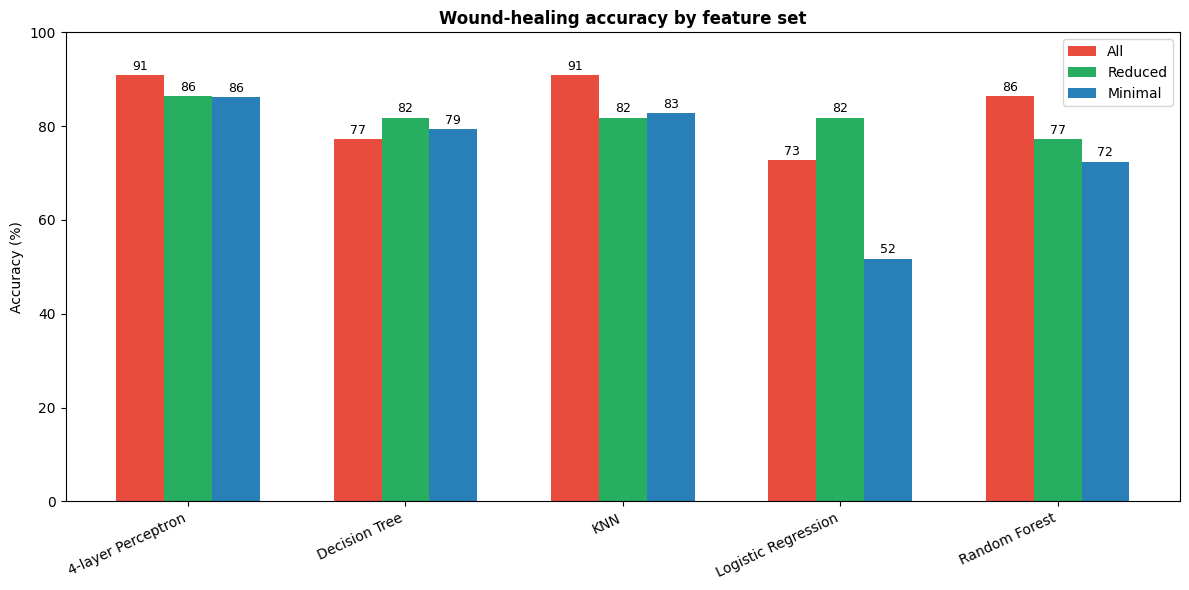


✔  Patients 2 or more-visits table: 109 patients 2 × 43 features
all             | Logistic Regression  : 84.00%  (n=25)
all             | Decision Tree        : 72.00%  (n=25)
all             | Random Forest        : 76.00%  (n=25)
all             | KNN                  : 84.00%  (n=25)
all             | 4‑layer Perceptron   : 80.00%  (n=25)
reduced         | Logistic Regression  : 88.00%  (n=25)
reduced         | Decision Tree        : 76.00%  (n=25)
reduced         | Random Forest        : 80.00%  (n=25)
reduced         | KNN                  : 72.00%  (n=25)
reduced         | 4‑layer Perceptron   : 80.00%  (n=25)
minimal         | Logistic Regression  : 51.43%  (n=35)
minimal         | Decision Tree        : 71.43%  (n=35)
minimal         | Random Forest        : 71.43%  (n=35)
minimal         | KNN                  : 77.14%  (n=35)
minimal         | 4‑layer Perceptron   : 71.43%  (n=35)

=== SUMMARY (patient 2‑level) ===


,all,reduced,minimal
Model,,,
4‑layer Perceptron,80.00%,80.00%,71.43%
Decision Tree,72.00%,76.00%,71.43%
KNN,84.00%,72.00%,77.14%
Logistic Regression,84.00%,88.00%,51.43%
Random Forest,76.00%,80.00%,71.43%


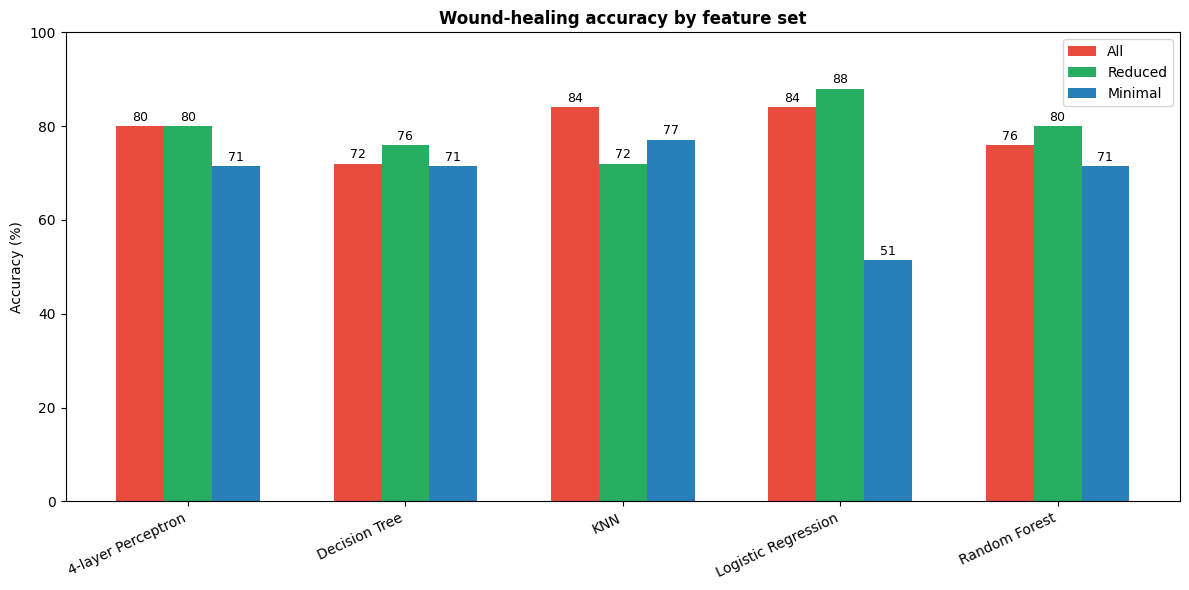


✔  Patient Baseline ‑ level table: 90 patients baseline × 43 features
all             | Logistic Regression  : 66.67%  (n=15)
all             | Decision Tree        : 93.33%  (n=15)
all             | Random Forest        : 86.67%  (n=15)
all             | KNN                  : 73.33%  (n=15)
all             | 4‑layer Perceptron   : 73.33%  (n=15)
reduced         | Logistic Regression  : 66.67%  (n=15)
reduced         | Decision Tree        : 86.67%  (n=15)
reduced         | Random Forest        : 86.67%  (n=15)
reduced         | KNN                  : 86.67%  (n=15)
reduced         | 4‑layer Perceptron   : 93.33%  (n=15)
minimal         | Logistic Regression  : 47.83%  (n=23)
minimal         | Decision Tree        : 73.91%  (n=23)
minimal         | Random Forest        : 73.91%  (n=23)
minimal         | KNN                  : 65.22%  (n=23)
minimal         | 4‑layer Perceptron   : 56.52%  (n=23)

=== SUMMARY (patient baseline‑level) ===


,all,reduced,minimal
Model,,,
4‑layer Perceptron,73.33%,93.33%,56.52%
Decision Tree,93.33%,86.67%,73.91%
KNN,73.33%,86.67%,65.22%
Logistic Regression,66.67%,66.67%,47.83%
Random Forest,86.67%,86.67%,73.91%


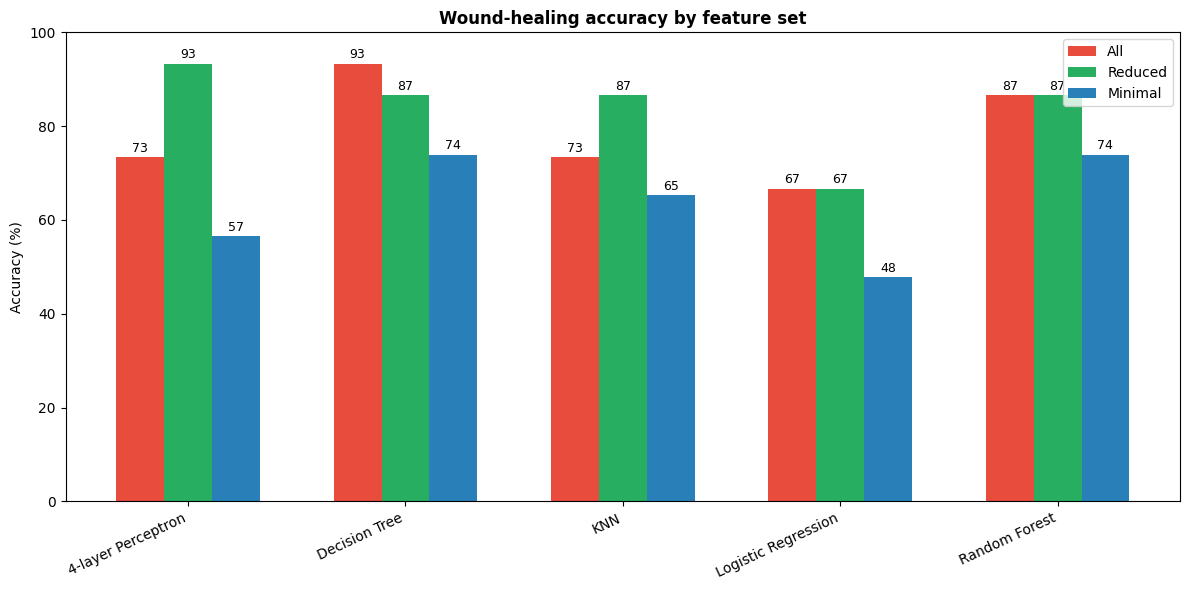

In [ ]:
# ============================================================================
# 0.  Imports & global switches
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

pd.set_option('future.no_silent_downcasting', True)

DATA_PATH      = Path("clinicaldata_april5_2021_wDx_updated.xlsx")
MIN_VISITS     = 3             #  patients must have ≥ this many encounters
BASELINE_ONLY  = False         #  True → enrolment visit only; False → per‑patient mean/mode
RANDOM_STATE   = 42

# ============================================================================
# 1.  Reading & light cleaning at **visit** level
# ============================================================================
def preprocess_visits(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = (df_raw.rename(columns=lambda c: c.strip().lower().replace(" ", "_"))
                .copy())

    # rename columns to eliminate duplicates
    rename_map = {
        "length_(cm)": "length_cm",
        "width_(cm)": "width_cm",
        "depth_(cm)": "depth_cm",
        "ph_both_values": "ph_combined",
        "ph_": "ph_alt",
        "peripheral_temperature": "peripheral_temp",
        "wound_temperature": "wound_temp"
    }
    df = df.rename(columns=rename_map)

    # check for duplicates
    dupes = df.columns[df.columns.duplicated()].tolist()
    if dupes:
        print("❌ Duplicate column names:", dupes)

    # replace categorical values safely
    recode_maps = {
        'ishealed': {'Yes': 1, 'No': 0},
        'gender': {'male': 0, 'female': 1, 'other': 2},
        'tobacco_use': {'non-smoker': 0, 'previous smoker': 1, 'current smoker': 2}
    }
    for col, mapping in recode_maps.items():
        if col in df.columns:
            df[col] = df[col].replace(mapping)

    # infer downcast types to suppress FutureWarning
    df = df.infer_objects(copy=False)

    # convert numerics
    numeric_cols = ['impedance', 'length_cm', 'width_cm', 'depth_cm',
                    'wound_temp', 'ph', 'ph_combined', 'ph_alt', 'tewl', 'age', 'weight', 'bmi']
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    return df

# ============================================================================
# 2.  Aggregate to **patient** level
# ============================================================================
def aggregate_patients(df_visits: pd.DataFrame,
                       baseline_only: bool = False,
                       min_visits: int = 3) -> pd.DataFrame:
    """Return one row per study_id after visit filtering."""
    # filter on visit count first
    vc        = df_visits['study_id'].value_counts()
    keep_ids  = vc[vc >= min_visits].index
    df_visits = df_visits[df_visits['study_id'].isin(keep_ids)].copy()

    # Exclude date columns from aggregation
    date_cols = [col for col in df_visits.columns if 'date' in col.lower()]
    df_visits_agg = df_visits.drop(columns=date_cols)

    cat_cols  = df_visits_agg.select_dtypes("object").columns
    num_cols  = df_visits_agg.drop(columns=cat_cols).select_dtypes("number").columns

    # how to collapse multiple visits?
    if baseline_only:
        # enrolment = earliest visit order within each patient
        df_visits_agg['__order'] = df_visits_agg.groupby('study_id').cumcount()
        df_patients = (df_visits_agg.sort_values(['study_id', '__order'])
                                  .groupby('study_id')
                                  .head(1)
                                  .set_index('study_id'))
    else:
        # numeric → mean; categorical → most common non‑NA
        def first_mode(s):
            try:
                return s.dropna().astype(str).mode().iloc[0]
            except Exception:
                return np.nan
        agg_dict = {**{c: 'mean' for c in num_cols},
                    **{c: first_mode for c in cat_cols}}
        df_patients = df_visits_agg.groupby('study_id').agg(agg_dict)

    return df_patients

# ============================================================================
# 3.  ML pipeline
# ============================================================================
def make_model_dict():
    return {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        'Decision Tree':       DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
        'Random Forest':       RandomForestClassifier(max_depth=5, n_estimators=30,
                                                      max_features=0.5, random_state=RANDOM_STATE),
        'KNN':                 KNeighborsClassifier(n_neighbors=2),
        '4‑layer Perceptron':  MLPClassifier(hidden_layer_sizes=(20,40,25,15),
                                             max_iter=10000, random_state=RANDOM_STATE)
    }

def run_ml_analysis(data, feature_sets):
    """Return tidy dataframe of accuracies (rows = models, cols = feature sets)."""
    results_dict = {}
    y_full = data['ishealed']

    for set_name, feat_cols in feature_sets.items():
        # keep complete‑case rows for this feature set + target
        subset = data.dropna(subset=feat_cols + ['ishealed'])
        X, y   = subset[feat_cols], subset['ishealed']

        # balance
        smote = SMOTE(random_state=RANDOM_STATE)
        Xb, yb = smote.fit_resample(X, y)

        # split once (80/20) to keep results comparable to your run
        X_tr, X_te, y_tr, y_te = train_test_split(
            Xb, yb, test_size=0.2, random_state=RANDOM_STATE, stratify=yb
        )

        # minimal preprocessing: scale numerics for LR / perceptron / KNN
        scaler = StandardScaler()
        preproc = ColumnTransformer([('num', scaler, feat_cols)],
                                    remainder='passthrough')

        accs = {}
        for name, mdl in make_model_dict().items():
            pipe = Pipeline(steps=[('prep', preproc), ('mdl', mdl)])
            pipe.fit(X_tr, y_tr)
            acc = accuracy_score(y_te, pipe.predict(X_te))
            accs[name] = acc
            print(f"{set_name:<15} | {name:<20} : {acc*100:5.2f}%  "
                  f"(n={len(y_te)})")
        results_dict[set_name] = accs
    return (pd.DataFrame(results_dict)
              .rename_axis("Model")
              .sort_index())

# ============================================================================
# 4.  Main run
# ============================================================================
raw_df   = pd.read_excel(DATA_PATH, sheet_name=0)
visits   = preprocess_visits(raw_df)
patients = aggregate_patients(visits, BASELINE_ONLY, MIN_VISITS)

print(f"\n✔  Patient 3rd or more visits table: {patients.shape[0]} patients 3-level × {patients.shape[1]} features")

# define your three feature packages
feature_sets = {
    'all':      ['wound_temp','impedance','tobacco_use','age','weight',
                 'length_cm','width_cm','depth_cm','gender','ph','tewl'],
    'reduced':  ['wound_temp','impedance','ph','tewl'],
    'minimal':  ['wound_temp','impedance']
}

results_df = run_ml_analysis(patients, feature_sets)

print("\n=== SUMMARY (patient 3‑level) ===")
display(results_df.style.format("{:.2%}"))

# ============================================================================
# 5.  Optional: bar‑plot like your Figure 2
# ============================================================================
def comparative_barplot(df, title="Wound‑healing accuracy by feature set"):
    colours = ['#e74c3c', '#27ae60', '#2980b9']  # red, green, blue
    x = np.arange(len(df.index))                 # models on x‑axis
    width = 0.22

    fig, ax = plt.subplots(figsize=(12,6))
    for idx, col in enumerate(df.columns):
        bars = ax.bar(x + idx*width, 100*df[col], width,
                      label=col.capitalize(), color=colours[idx])
        # label on top
        for b in bars:
            ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.5,
                    f"{b.get_height():.0f}", ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x + width)
    ax.set_xticklabels(df.index, rotation=25, ha='right')
    ax.set_ylabel("Accuracy (%)")
    ax.set_title(title, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.legend()
    plt.tight_layout()
    plt.show()

comparative_barplot(results_df)

patients_2 = aggregate_patients(visits, BASELINE_ONLY, 2)
print(f"\n✔  Patients 2 or more-visits table: {patients_2.shape[0]} patients 2 × {patients_2.shape[1]} features")
results_2df = run_ml_analysis(patients_2, feature_sets)
print("\n=== SUMMARY (patient 2‑level) ===")
display(results_2df.style.format("{:.2%}"))
comparative_barplot(results_2df)


patients_b = aggregate_patients(visits, baseline_only = True, min_visits=3)
print(f"\n✔  Patient Baseline ‑ level table: {patients_b.shape[0]} patients baseline × {patients_b.shape[1]} features")
results_bdf = run_ml_analysis(patients_b, feature_sets)
print("\n=== SUMMARY (patient baseline‑level) ===")
display(results_bdf.style.format("{:.2%}"))
comparative_barplot(results_bdf)
# ============================================================================
# 6.  Persist outputs
# ============================================================================
# results_df.to_csv("outputs/ML_accuracy_patient_level.csv")

# Cross - Validation techniques with Feature Importance:

In [ ]:
# ============================================================================
# 7.  Cross-validated accuracy  +  fold-averaged feature importance
# ============================================================================

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.inspection import permutation_importance

cv          = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
acc_cv_tbl  = {}      # {(feature_set, model) : (mean, sd)}
imp_cv_dict = {}      # {(feature_set, model) : pd.Series}

def get_coef(estimator):            # linear models
    return np.abs(estimator.coef_).ravel()

def get_importance(estimator):      # tree / forest
    return estimator.feature_importances_

for set_name, feat_cols in feature_sets.items():
    subset = patients_2.dropna(subset=feat_cols + ['ishealed'])
    X, y   = subset[feat_cols], subset['ishealed']

    for mdl_name, mdl in make_model_dict().items():
        pipe = Pipeline([
            ('prep', ColumnTransformer([('num', StandardScaler(), feat_cols)],
                                       remainder='passthrough')),
            ('mdl',  mdl)
        ])

        cv_res = cross_validate(pipe, X, y, cv=cv,
                                scoring='accuracy',
                                return_estimator=True, n_jobs=-1)
        mean_acc = cv_res['test_score'].mean()
        sd_acc   = cv_res['test_score'].std(ddof=1)
        acc_cv_tbl[(set_name, mdl_name)] = (mean_acc, sd_acc)

        # -------- feature importance averaged across folds --------
        fold_imps = []
        for est in cv_res['estimator']:
            m = est.named_steps['mdl']
            if hasattr(m, 'feature_importances_'):
                fold_imps.append(get_importance(m))
            elif hasattr(m, 'coef_'):
                fold_imps.append(get_coef(m))
            else:                       # e.g. KNN  ▸ permutation on that fold
                pi = permutation_importance(est, X, y, n_repeats=20,
                                             random_state=RANDOM_STATE)
                fold_imps.append(pi.importances_mean)
        imp_cv_dict[(set_name, mdl_name)] = (
            pd.Series(np.mean(fold_imps, axis=0),
                      index=feat_cols).sort_values(ascending=False)
        )

# Create a list of dictionaries to build the DataFrame
data_for_df = []
for (fs, mdl), (mean, sd) in acc_cv_tbl.items():
    data_for_df.append({'Feature Set': fs, 'Model': mdl, 'Accuracy': f"{mean*100:5.2f}% ± {sd*100:4.2f}"})

cv_df = pd.DataFrame(data_for_df)
cv_df = cv_df.pivot(index='Model', columns='Feature Set', values='Accuracy')

print("\n=== 5-fold cross-validated accuracy (patient2-level) ===")
display(cv_df)

# ------------------------- show importances for top model -------------------
best_pair = max(acc_cv_tbl, key=lambda k: acc_cv_tbl[k][0])   # highest mean acc
print(f"\nTop performer:  feature set = {best_pair[0]!r},  model = {best_pair[1]!r}")
display(imp_cv_dict[best_pair].to_frame("↑ importance").head(15))


=== 5-fold cross-validated accuracy (patient2-level) ===


Feature Set,all,minimal,reduced
Model,,,
4‑layer Perceptron,73.75% ± 6.99,69.61% ± 8.92,76.18% ± 8.34
Decision Tree,82.13% ± 4.19,76.15% ± 4.95,78.60% ± 9.76
KNN,71.54% ± 5.99,78.87% ± 2.72,76.18% ± 7.23
Logistic Regression,79.85% ± 6.49,77.97% ± 2.20,80.96% ± 6.41
Random Forest,84.49% ± 3.45,82.60% ± 3.66,80.88% ± 7.92



Top performer:  feature set = 'all',  model = 'Random Forest'


,↑ importance
depth_cm,0.277169
tewl,0.153397
width_cm,0.099131
length_cm,0.096803
age,0.094297
wound_temp,0.076807
impedance,0.065621
ph,0.063436
weight,0.043070
tobacco_use,0.020952


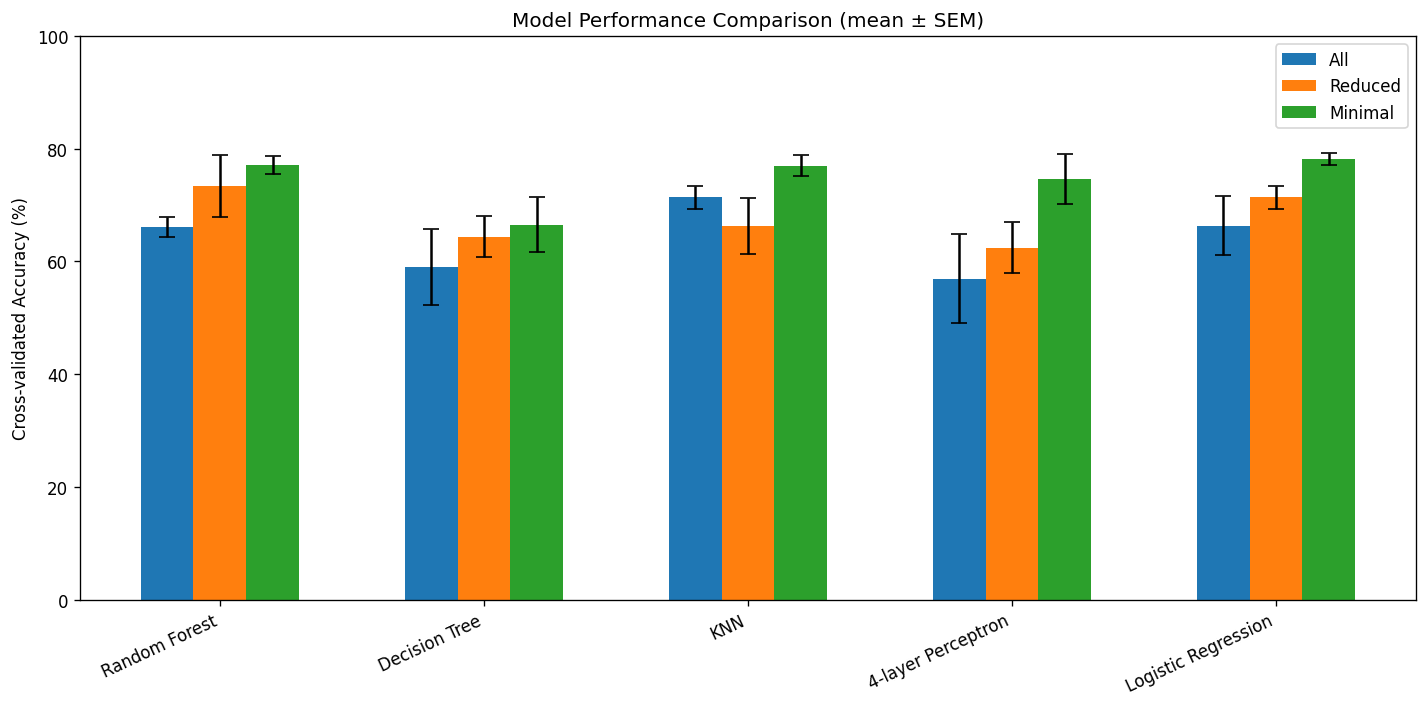

In [ ]:
def plot_cv_bars(acc_cv_tbl, feature_sets, use_sem=False):
    """
    Plots a grouped bar chart of cross-validated accuracy with error bars.
    acc_cv_tbl: dict {(feature_set, model) : (mean, sd)}
    feature_sets: dict of feature_set_name : [features]
    use_sem: If True, plot SEM instead of SD
    """
    # Models and feature sets order
    models = list({mdl for (_, mdl) in acc_cv_tbl})
    fs_names = list(feature_sets.keys())

    # Build means and errors
    means = np.array([[acc_cv_tbl.get((fs, mdl), (np.nan, np.nan))[0] for fs in fs_names] for mdl in models])
    sds   = np.array([[acc_cv_tbl.get((fs, mdl), (np.nan, np.nan))[1] for fs in fs_names] for mdl in models])
    ns    = len(models)  # could be n_splits*n_repeats; here, use SD unless SEM desired

    errors = sds if not use_sem else sds / np.sqrt(ns)

    # Bar chart
    x = np.arange(len(models))
    width = 0.2
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, fs in enumerate(fs_names):
        ax.bar(x + i*width, 100*means[:,i], width, yerr=100*errors[:,i],
               capsize=5, label=fs.capitalize())

    ax.set_xticks(x + width*(len(fs_names)-1)/2)
    ax.set_xticklabels(models, rotation=25, ha='right')
    ax.set_ylabel("Cross-validated Accuracy (%)")
    ax.set_title("Model Performance Comparison (mean ± %s)" % ('SD' if not use_sem else 'SEM'))
    ax.set_ylim(0, 100)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_cv_bars(acc_cv_tbl, feature_sets, use_sem=True)    # SEM error bars (smaller)

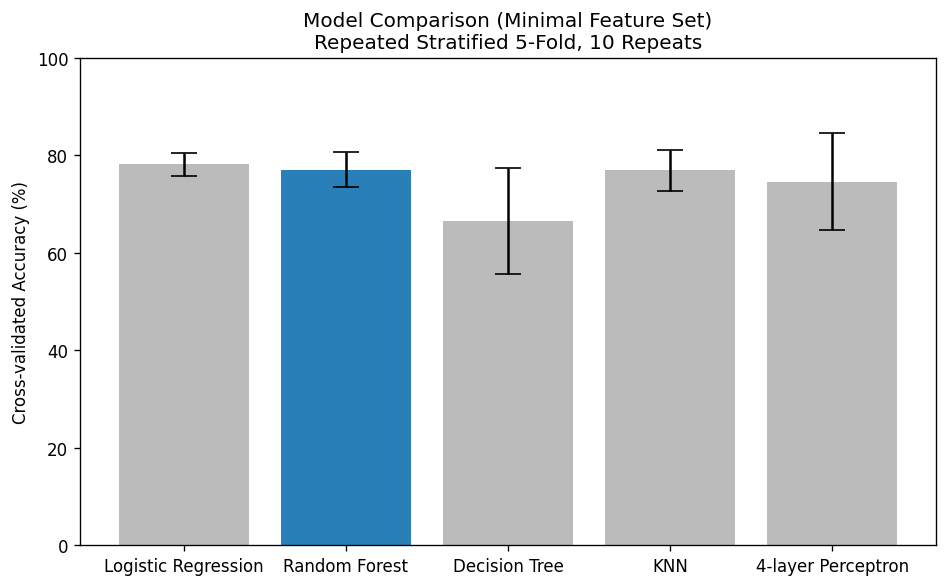

In [ ]:
def plot_minimal_model_cv(acc_cv_tbl, models=['Logistic Regression','Random Forest','Decision Tree','KNN','4‑layer Perceptron'], feature_set='minimal', use_sem=False):
    means = []
    errors = []
    for m in models:
        mean, sd = acc_cv_tbl.get((feature_set, m), (np.nan, np.nan))
        means.append(mean)
        errors.append(sd)
    means = np.array(means)
    errors = np.array(errors)
    if use_sem:
        errors = errors / np.sqrt(10*5)  # n_repeats * n_folds, adjust as per your actual repeats

    plt.figure(figsize=(8,5))
    bars = plt.bar(models, 100*means, yerr=100*errors, capsize=8, color=['#2980b9' if m=='Random Forest' else '#bbb' for m in models])
    plt.ylabel("Cross-validated Accuracy (%)")
    plt.title("Model Comparison (Minimal Feature Set)\nRepeated Stratified 5-Fold, 10 Repeats")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# Suppose acc_cv_tbl already populated from repeated CV block:
plot_minimal_model_cv(acc_cv_tbl, use_sem=False)   # Use SD as error bars

In [ ]:
# ------------------------------------------------------------------
# 8.  Repeated stratified 5-fold (10 repeats) + odds-ratios for LR
# ------------------------------------------------------------------
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import scipy.stats as st

RPT_CV = RepeatedStratifiedKFold(n_splits=5, n_repeats=10,
                                 random_state=RANDOM_STATE)

feat_cols = feature_sets['minimal']          # top performer’s inputs
subset = patients_b.dropna(subset=feat_cols + ['ishealed'])
X = subset[feat_cols]
y = subset['ishealed']

pipe_lr = Pipeline([
    ('prep', ColumnTransformer([('num', StandardScaler(), feat_cols)],
                               remainder='passthrough')),
    ('mdl',  LogisticRegression(penalty='l2', C=1.0,
                                max_iter=1000, random_state=RANDOM_STATE))
])

# --- repeated CV predictions ---
# Manually perform predictions using the splits from RepeatedStratifiedKFold
y_true_concat = []
y_pred_concat = []
y_prob_concat = []
indices_concat = []

for train_index, test_index in RPT_CV.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_lr.fit(X_train, y_train)

    y_pred_concat.extend(pipe_lr.predict(X_test))
    y_prob_concat.extend(pipe_lr.predict_proba(X_test)[:, 1])
    y_true_concat.extend(y_test)
    indices_concat.extend(test_index)

# Since RepeatedStratifiedKFold does not provide a single partition,
# there will be duplicate predictions for some data points.
# To get metrics over the entire dataset without double-counting,
# we can average or take the last prediction for each data point.
# However, for standard classification metrics like accuracy, confusion matrix,
# and classification report, we should use the predictions and true labels
# aggregated across all folds and repetitions.

# Convert lists to numpy arrays for metric calculations
y_true_concat = np.array(y_true_concat)
y_pred_concat = np.array(y_pred_concat)
y_prob_concat = np.array(y_prob_concat)

print("Accuracy:", (y_pred_concat == y_true_concat).mean().round(4))
print("AUC-ROC :", roc_auc_score(y_true_concat, y_prob_concat).round(4))
print(confusion_matrix(y_true_concat, y_pred_concat))
print(classification_report(y_true_concat, y_pred_concat, digits=3))

# --- fit once to get coefficients, then bootstrap CIs ---
pipe_lr.fit(X, y)
coefs = pipe_lr.named_steps['mdl'].coef_.ravel()

# bootstrap
boot = []
rng = np.random.default_rng(RANDOM_STATE)
for _ in range(2_000):
    idx = rng.choice(len(y), len(y), replace=True)
    pipe_lr.fit(X.iloc[idx], y.iloc[idx])
    boot.append(pipe_lr.named_steps['mdl'].coef_.ravel())
boot = np.array(boot)

ci_low, ci_high = np.percentile(np.exp(boot), [2.5, 97.5], axis=0)

odds_tbl = (pd.DataFrame({
                'odds_ratio': np.exp(coefs),
                'CI_low':     ci_low,
                'CI_high':    ci_high},
             index=feat_cols)
              .sort_values('odds_ratio', ascending=False))
display(odds_tbl)

Accuracy: 0.777
AUC-ROC : 0.4001
[[676   4]
 [190   0]]
              precision    recall  f1-score   support

         0.0      0.781     0.994     0.875       680
         1.0      0.000     0.000     0.000       190

    accuracy                          0.777       870
   macro avg      0.390     0.497     0.437       870
weighted avg      0.610     0.777     0.684       870



,odds_ratio,CI_low,CI_high
wound_temp,1.097502,0.662766,1.822970
impedance,0.955940,0.613116,1.448233


In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ('prep', ColumnTransformer([('num', StandardScaler(), feat_cols)], remainder='passthrough')),
    ('mdl', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE))
])

# --- repeated CV predictions ---
# Manually perform predictions using the splits from RepeatedStratifiedKFold
y_true_concat = []
y_pred_concat = []
y_prob_concat = []
indices_concat = []

for train_index, test_index in RPT_CV.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_rf.fit(X_train, y_train)

    y_pred_concat.extend(pipe_rf.predict(X_test))
    y_prob_concat.extend(pipe_rf.predict_proba(X_test)[:, 1])
    y_true_concat.extend(y_test)
    indices_concat.extend(test_index)

# Convert lists to numpy arrays for metric calculations
y_true_concat = np.array(y_true_concat)
y_pred_concat = np.array(y_pred_concat)
y_prob_concat = np.array(y_prob_concat)

print("Accuracy:", (y_pred_concat == y_true_concat).mean().round(4))
print("AUC-ROC :", roc_auc_score(y_true_concat, y_prob_concat).round(4))
print(confusion_matrix(y_true_concat, y_pred_concat))
print(classification_report(y_true_concat, y_pred_concat, digits=3))


Accuracy: 0.7333
AUC-ROC : 0.5688
[[629  51]
 [181   9]]
              precision    recall  f1-score   support

         0.0      0.777     0.925     0.844       680
         1.0      0.150     0.047     0.072       190

    accuracy                          0.733       870
   macro avg      0.463     0.486     0.458       870
weighted avg      0.640     0.733     0.676       870



# Choosing Random Forest to build the Confusion Matrix and Final ROC Curves:

Best F1 = 0.381 at threshold = 0.16


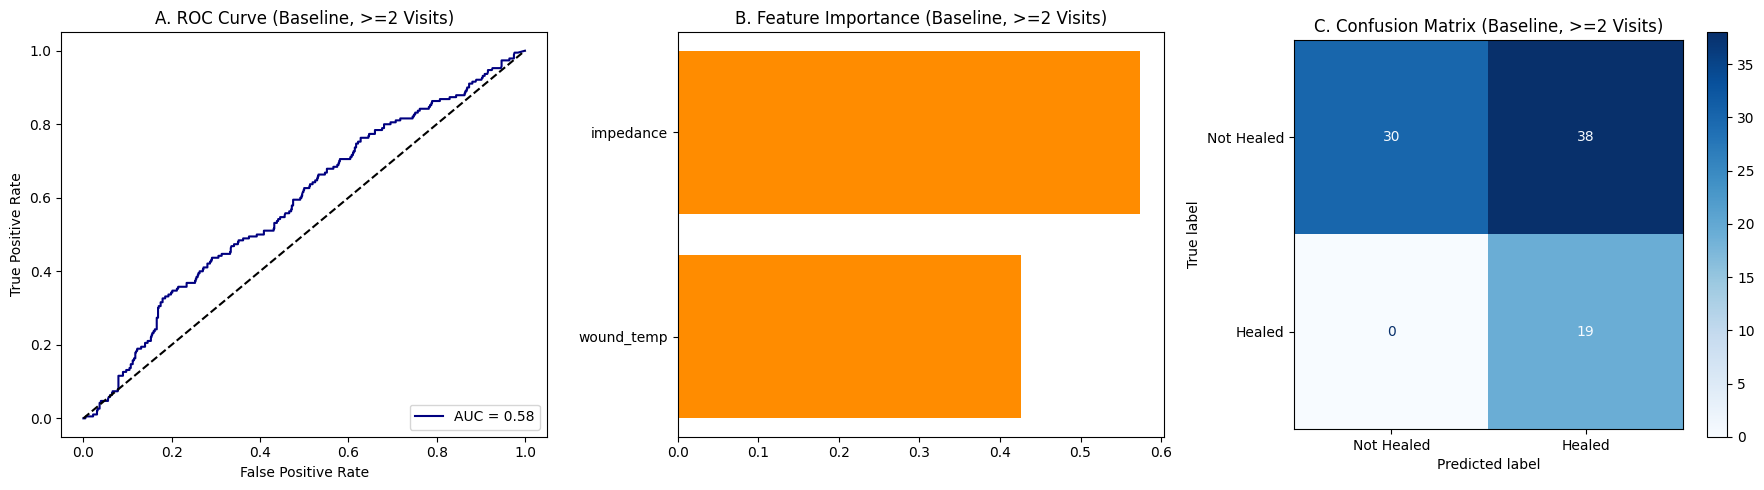

Best F1 = 0.441 at threshold = 0.30


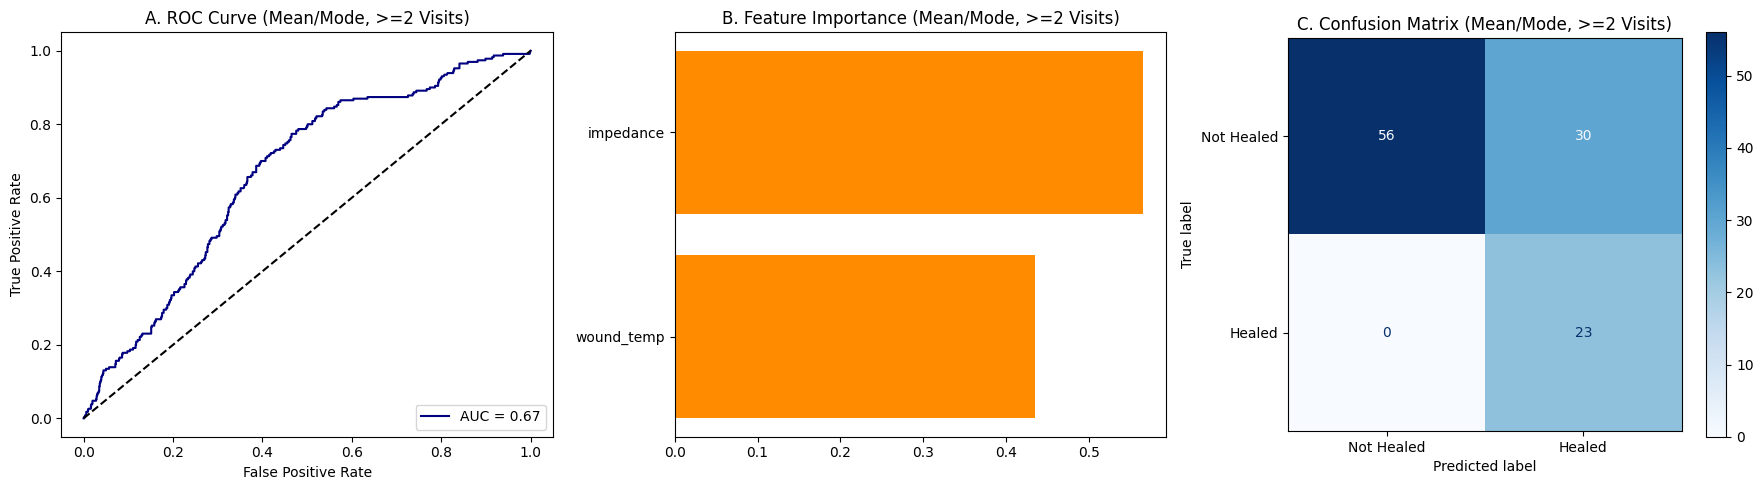

Best F1 = 0.481 at threshold = 0.28


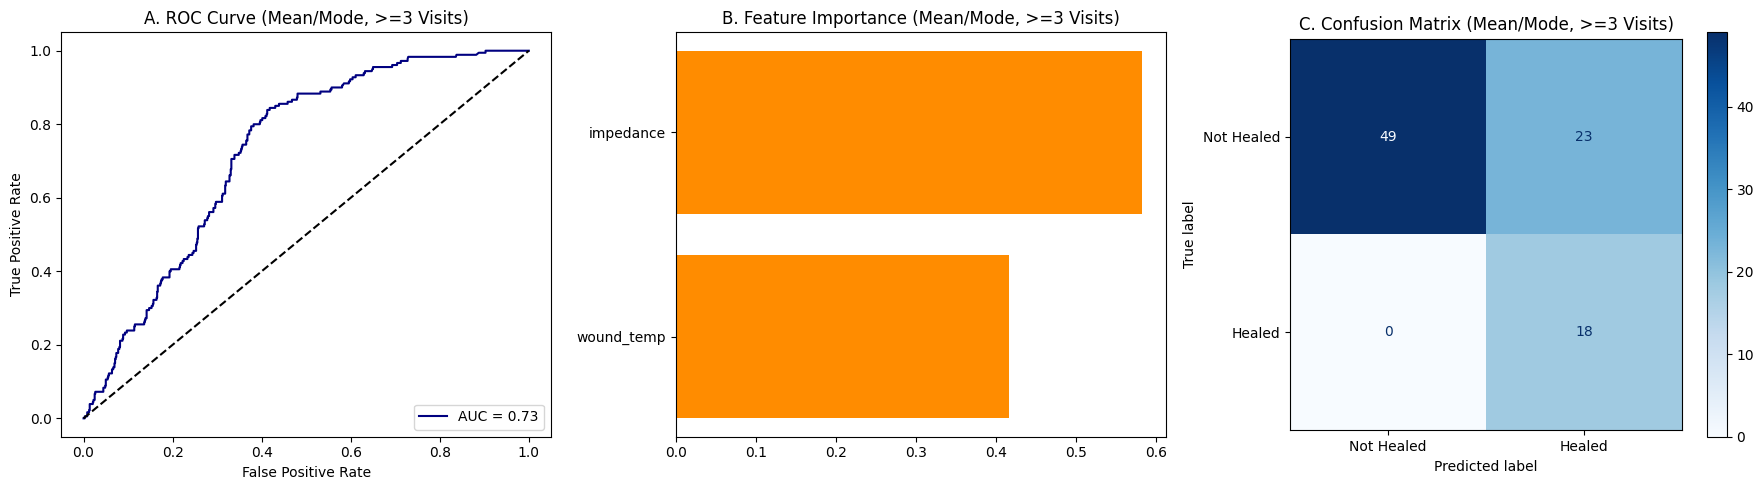

In [ ]:
# publication_figures.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline # Use ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer # Import SimpleImputer
from sklearn.pipeline import Pipeline # Import standard Pipeline for ColumnTransformer

RANDOM_STATE = 42


def generate_rf_figure(X, y, feature_names, title_suffix=""):
    # Drop rows with NaNs in the selected features or target
    data_subset = pd.concat([X, y], axis=1).dropna(subset=feature_names + [y.name])
    X_cleaned = data_subset[feature_names]
    y_cleaned = data_subset[y.name]


    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=RANDOM_STATE)

    # Create the full pipeline including preprocessing, SMOTE, and the model
    pipe = ImbPipeline([
        ('imputer', SimpleImputer(strategy='mean')), # Handle NaNs
        ('scaler', StandardScaler()), # Scale the features
        ('smote', SMOTE(random_state=RANDOM_STATE)), # Apply SMOTE
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE)) # Train the model
    ])

    # Cross-val predicted probabilities - Manual approach for RepeatedStratifiedKFold
    y_proba_list = []
    y_true_list = []

    for train_index, test_index in rskf.split(X_cleaned, y_cleaned):
        X_train, X_test = X_cleaned.iloc[train_index], X_cleaned.iloc[test_index]
        y_train, y_test = y_cleaned.iloc[train_index], y_cleaned.iloc[test_index]

        pipe.fit(X_train, y_train)
        y_proba_list.append(pipe.predict_proba(X_test)[:, 1])
        y_true_list.append(y_test)

    y_proba = np.concatenate(y_proba_list)
    y_true = np.concatenate(y_true_list)

    # To handle repeated predictions for the same data points, we can average the probabilities
    # or just use the concatenated list as is for metrics like ROC and PR curves,
    # as these metrics work on pairs of (true, predicted_proba).
    # For metrics like confusion matrix, we need to be careful about duplicates.
    # However, for simplicity and consistency with the original intent of cross_val_predict
    # in this context (getting predictions for plotting curves across all data points),
    # we will use the concatenated lists directly for ROC and PR curves.
    # For the confusion matrix, we will fit on the entire dataset and predict.

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
    best_f1 = f1_scores.max()
    best_idx = f1_scores.argmax()
    best_thresh = thr[best_idx]
    print(f"Best F1 = {best_f1:.3f} at threshold = {best_thresh:.2f}")


    # Confusion Matrix (fit on entire dataset for a single matrix)
    pipe.fit(X_cleaned, y_cleaned)
    y_pred = (pipe.predict_proba(X_cleaned)[:,1] >= best_thresh).astype(int) # Use best threshold from PR curve
    cm = confusion_matrix(y_cleaned, y_pred)

    # Feature importances (from fitting on the entire dataset)
    importances = pipe.named_steps['rf'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='navy')
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(f'A. ROC Curve{title_suffix}')
    axes[0].legend(loc='lower right')

    axes[1].barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='darkorange')
    axes[1].set_title(f'B. Feature Importance{title_suffix}')
    axes[1].invert_yaxis()

    # Use the confusion matrix calculated with the best threshold
    ConfusionMatrixDisplay(cm, display_labels=['Not Healed', 'Healed']).plot(ax=axes[2], cmap='Blues')
    axes[2].set_title(f'C. Confusion Matrix{title_suffix}')

    plt.tight_layout()
    plt.show()

# Call this function three times, like:
# Need to create patients_3 first
patients_3 = aggregate_patients(visits, BASELINE_ONLY, 3)

generate_rf_figure(patients_b[['wound_temp','impedance']], patients_b['ishealed'], ['wound_temp','impedance'], title_suffix=' (Baseline, >=2 Visits)')
generate_rf_figure(patients_2[['wound_temp','impedance']], patients_2['ishealed'], ['wound_temp','impedance'], title_suffix=' (Mean/Mode, >=2 Visits)')
generate_rf_figure(patients_3[['wound_temp','impedance']], patients_3['ishealed'], ['wound_temp','impedance'], title_suffix=' (Mean/Mode, >=3 Visits)')

# Slopes and Probability Ranges for Effective Treatment Zones:

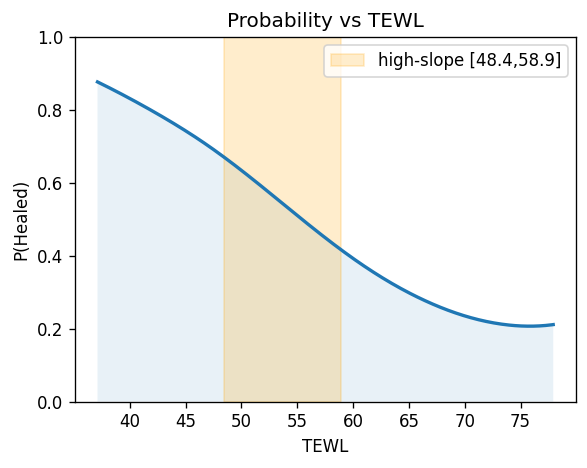

TEWL high-slope band: 48.4 – 58.9


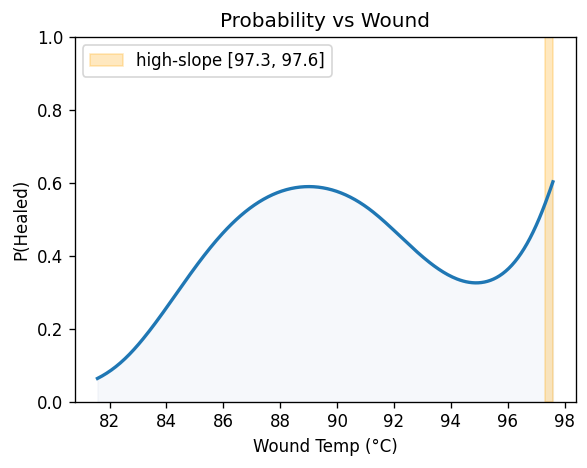

Wound Temp (°C) high-slope band: 97.3 – 97.6


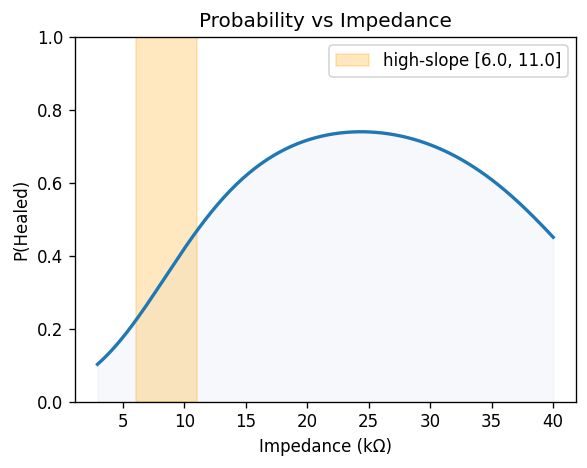

Impedance (kΩ) high-slope band: 6.0 – 11.0


In [ ]:
# =====================================================
# 0.  Boiler-plate (run once per notebook) -------------
# =====================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import pairwise_distances
RANDOM_STATE = 42
plt.rcParams["figure.dpi"] = 120

# Helper: simple bootstrap CI
def bootstrap_ci(vals, n=200, alpha=0.05):
    rng = np.random.default_rng(RANDOM_STATE)
    boot = rng.choice(vals, (n,len(vals)), replace=True)
    est  = boot.mean(1)
    return np.percentile(est, [100*alpha/2, 100*(1-alpha/2)])

# =====================================================
# 1.  Upload workbook & reuse earlier helpers ----------
# =====================================================
DATA_PATH = Path("clinicaldata_april5_2021_wDx_updated.xlsx")
visits = preprocess_visits(pd.read_excel(DATA_PATH, sheet_name=0))
patients = aggregate_patients(visits, min_visits=2)     # <= change to 3 if you want

# Define covariates for context
MAIN_FEATS = ['wound_temp','impedance','ph','tewl','age','weight']
data = patients.dropna(subset=MAIN_FEATS+['ishealed'])

# =====================================================
# 2.  Stand-alone GAM for TEWL ------------------------
# =====================================================
var = 'tewl'
X_t, y_t = data[[var]].values, data['ishealed'].values

pipe_t = make_pipeline(
    SplineTransformer(n_knots=5, degree=3),
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=2000, class_weight='balanced')
)
pipe_t.fit(X_t, y_t)

xx  = np.linspace(np.nanpercentile(X_t,5), np.nanpercentile(X_t,95), 300).reshape(-1,1)
p   = pipe_t.predict_proba(xx)[:,1]
dp  = np.gradient(p, xx.ravel())

thr = 0.9*np.max(np.abs(dp))
band= xx.ravel()[np.abs(dp)>=thr]

plt.figure(figsize=(5,4))
plt.plot(xx, p, lw=2)
plt.fill_between(xx.ravel(), p, alpha=0.1)
if band.size:
    plt.axvspan(band.min(), band.max(), color='orange', alpha=0.2,
                label=f'high-slope [{band.min():.1f},{band.max():.1f}]')
plt.ylim(0,1); plt.xlabel('TEWL'); plt.ylabel('P(Healed)')
plt.title('Probability vs TEWL'); plt.legend(); plt.tight_layout()
# plt.savefig('pdp_tewl.png', dpi=300)
plt.show()

print("TEWL high-slope band:",
      f"{band.min():.1f} – {band.max():.1f}" if band.size else "none detected")

# =====================================================
# 3.  Single-feature spline logit for temp & impedance
# =====================================================
ONE_D_VARS = {
    'wound_temp': dict(label='Wound Temp (°C)', n_knots=4),
    'impedance' : dict(label='Impedance (kΩ)',  n_knots=4)
}

for var, cfg in ONE_D_VARS.items():
    Xv = data[[var]].values
    yv = data['ishealed'].values

    pipe_v = make_pipeline(
        SplineTransformer(n_knots=cfg['n_knots'], degree=3),
        StandardScaler(with_mean=False),
        LogisticRegression(max_iter=2000, class_weight='balanced')
    )
    pipe_v.fit(Xv, yv)

    # focus on the central 5-95 % range to avoid tails with < 3 patients
    lo, hi = np.nanpercentile(Xv, [5, 95])
    xx = np.linspace(lo, hi, 300).reshape(-1, 1)

    p  = pipe_v.predict_proba(xx)[:, 1]
    dp = np.gradient(p, xx.ravel())

    thr = 0.9 * np.max(np.abs(dp))          # 80 % of steepest slope
    band = xx.ravel()[np.abs(dp) >= thr]

    plt.figure(figsize=(5, 4))
    plt.plot(xx, p, lw=2)
    plt.fill_between(xx.ravel(), p, alpha=0.10, color='#B0C4DE')
    if band.size:
        plt.axvspan(band.min(), band.max(),
                    color='orange', alpha=0.25,
                    label=f'high-slope [{band.min():.1f}, {band.max():.1f}]')
    plt.ylim(0, 1)
    plt.xlabel(cfg['label'])
    plt.ylabel('P(Healed)')
    plt.title(f'Probability vs {cfg["label"].split()[0]}')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"pdp_{var}.png", dpi=300)
    plt.show()

    print(f"{cfg['label']} high-slope band:",
          f"{band.min():.1f} – {band.max():.1f}" if band.size else "none detected")


Error, needs fixing below:

In [ ]:
# publication_figures AUROC Curves:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold # Removed GridSearchCV
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42

def generate_rf_figure(X, y, feature_sets: dict, title_suffix=""):
    # Drop rows with NaNs across all feature sets + target
    required_cols = list(set(col for fs in feature_sets.values() for col in fs))
    # Force y to be a Series with a name (in case it's a DataFrame)
    if isinstance(y, pd.DataFrame):
        assert y.shape[1] == 1, "y must be a single-column DataFrame or Series"
        y = y.iloc[:, 0]

    data_subset = pd.concat([X, y], axis=1).dropna(subset=required_cols + [y.name])

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['navy', 'darkgreen', 'darkred', 'purple']

    for idx, (label, feature_names) in enumerate(feature_sets.items()):
        X_clean = data_subset[feature_names]
        # Ensure y_clean is a Series and convert to numpy array with integer type
        # Convert to NumPy array with integer type explicitly here
        y_clean = np.asarray(data_subset[y.name]).astype(int).ravel()
        print(f"y_clean type: {type(y_clean)}, dtype: {y_clean.dtype}, unique: {np.unique(y_clean)}")
        print(f"X_clean shape: {X_clean.shape}, y_clean shape: {y_clean.shape}")
        print(f"NaNs in X_clean: {X_clean.isna().sum().sum()}")
        print(f"Infs in X_clean: {np.isinf(X_clean).sum().sum()}")

        rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=RANDOM_STATE)

        # Define preprocessing pipeline
        preprocessing_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')), # Handle NaNs
            ('scaler', StandardScaler()) # Scale the features
        ])

        # Create the full ImbPipeline with preprocessing, SMOTE, and the model
        # Removed GridSearchCV and simplified the model
        pipe = ImbPipeline([
            ('preprocessing', preprocessing_pipeline),
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('rf', RandomForestClassifier(n_estimators=300, max_depth=8, random_state=RANDOM_STATE)) # Using reasonable parameters
        ])

        y_proba_list = []
        y_true_list = []

        # Manually iterate through splits for cross-validation predictions
        # Use the integer numpy array y_clean directly in the split
        for train_index, test_index in rskf.split(X_clean, y_clean):
            X_train, X_test = X_clean.iloc[train_index], X_clean.iloc[test_index]
            y_train, y_test = y_clean[train_index], y_clean[test_index] # Use numpy indexing for y_clean

            # Fit the best pipeline on the current training fold
            pipe.fit(X_train, y_train)

            # Predict probabilities on the current test fold
            y_proba_list.append(pipe.predict_proba(X_test)[:, 1])
            y_true_list.append(y_test)

        y_proba = np.concatenate(y_proba_list)
        y_true = np.concatenate(y_true_list)

        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)

        # Precision-Recall
        prec, rec, thr = precision_recall_curve(y_true, y_proba)
        f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
        best_f1 = f1_scores.max()
        best_idx = f1_scores.argmax()
        best_thresh = thr[best_idx]
        print(f"[{label}] Best F1 = {f1_scores[best_idx]:.3f} at threshold = {best_thresh:.2f}",
              f"(precision {prec[best_idx]:.2f}, recall {rec[best_idx]:.2f})")

        # Confusion Matrix (fit on entire dataset with best threshold)
        # Refit the pipeline on the entire cleaned dataset to get final feature importances and confusion matrix
        pipe.fit(X_clean, y_clean)
        y_pred = (pipe.predict_proba(X_clean)[:,1] >= best_thresh).astype(int)
        cm = confusion_matrix(y_clean, y_pred)

        # Feature importances (from fitting on the entire dataset)
        # Access feature importances from the 'rf' step within the pipeline
        importances = pipe.named_steps['rf'].feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        # Plot on the provided axes object
        ax.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', color=colors[idx % len(colors)])

        # Optional: Display confusion matrix and feature importance for each feature set
        print(f"\n[{label}] Confusion Matrix:")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Healed', 'Healed'])
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f'Confusion Matrix - {label}{title_suffix}')
        plt.show()

        print(f"\n[{label}] Feature Importance:")
        display(feature_importance_df)

    # Add common plot elements after the loop for the main ROC curve comparison plot
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve Comparison{title_suffix}')
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Call this function three times, like:
feature_sets = {
    'Minimal': ['wound_temp', 'impedance'],
    'Reduced': ['wound_temp', 'impedance', 'ph', 'tewl'],
    'All':     ['wound_temp','impedance','tobacco_use','age','weight','length_cm','width_cm','depth_cm','gender','ph','tewl']
}
generate_rf_figure(patients_3, patients_3['ishealed'], feature_sets, title_suffix=' (>=3 Visits)')